In [1]:
import csv

import matplotlib
matplotlib.use('nbagg')
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd

In [2]:
# Load in the data into a multi-index frame
labels = sorted(
    open("data/reference/label_order.csv").read().strip().split(',')
)

# Bar plot function definition

dfs : `dict`
    
    A dictionary of conditions to plot. The keys should be what you would like displayed in the legend.

cmap : `list`
    
    A list of floats indicating gray scale tone to use for each bar in a single subplot. 0 is black, 1 is white.

labels : `list`
    
    List of labels corresponding to each subplot.

In [3]:
def basic_bar_plot(dfs, cmap, labels, metric="Binary F1", keys_are_metrics=False, yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                   yticklabels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], legend_colspan=2, legend_pos="upper left",
                   gs_rows=3, gs_cols=8, gs_params=dict(left=0.05, right=0.95, wspace=0.1, hspace=0.4), plot_subsets=False, 
                   ecolor="black", edgecolor="white", fontsize=8, subset_fontsize=7, center_left=None, center_right=None,
                   use_subset_ticks=True):
    
    f = plt.figure()
    gs = GridSpec(gs_rows, gs_cols)
    gs.update(**gs_params)
    axes = []
    
    for i in range(0, gs_rows):
        for j in range(0, gs_cols - legend_colspan):
            row_maj_idx = 6*i + j
            label = labels[row_maj_idx]

            ax = plt.subplot(gs[i, j])
            axes.append(ax)
            ax.margins(0.05)

            # Limits config
            ax.set_ylim(bottom=0.0)
            ax.set_ylim(top=1.0)

            # Ticks config
            ax.set_xticks([])
            ax.set_yticks([])

            ax.set(yticks=yticks, yticklabels=[])
            minor_ticks = MultipleLocator(0.1)
            ax.yaxis.set_minor_locator(minor_ticks)
            ax.tick_params(axis='y', which='major', direction='in', length=3.0, labelsize=8)
            ax.tick_params(axis='y', which='minor', direction='in', length=1.5, labelsize=8)
            if row_maj_idx in [0, 6, 12]:
                ax.set(yticklabels=yticklabels)

            # Title config
            ax.set_title(label.capitalize())
            ax.title.set_fontsize(fontsize)

            # plot the data for each metric, using gray-scale colors               
            # Plot testing statistics for phosphorylation and dephosphorylation
            if label in ('phosphorylation', 'dephosphorylation') and plot_subsets:
                gap = 0.025
                bar_width = (0.5 - gap) / len(dfs)
                validation_x = np.arange(0, 0.5 - gap, bar_width)
                holdout_x = np.arange(0.5 + gap, 1.0, bar_width)
                subset_x = {"validation": validation_x, "holdout": holdout_x}

                for idx, subset in enumerate(('validation', 'holdout')):               
                    for bar_idx, (key, df) in enumerate(dfs.items()):
                        metric_key = key if keys_are_metrics else metric
                        score = df.loc[(label, subset, metric_key), :].mean(axis=0, level=[0]).mean()
                        stdev = binary_df.loc[(label, subset, metric_key), :].std(axis=0, level=[0]).mean()
                        stderr = stdev / np.sqrt(25) # 5 bootstrap * 5 fold = 25 observations
                        ax.bar(
                            left=subset_x[subset][bar_idx], height=score, width=bar_width, yerr=stderr,
                            color=str(cmap[bar_idx]), ecolor=ecolor, edgecolor=edgecolor, linewidth=1.0,
                            error_kw=dict(lw=0.5, capsize=2.5, label=key)
                        )
                        
                    if not center_left:
                        center_left = validation_x[int(len(dfs) / 2)]
                    if not center_right:
                        center_right = holdout_x[int(len(dfs) / 2)]                        
                    if use_subset_ticks:
                        ax.set(xticks=[center_left, center_right], xticklabels=['Validation', 'Holdout'])
                        ax.tick_params(axis='x', direction='in', length=2.5, labelsize=subset_fontsize)

            else:
                bar_width = 1.0 / len(dfs)
                x_positions = np.arange(0, 1, bar_width)
                for idx, (key, df) in enumerate(dfs.items()):
                    metric_key = key if keys_are_metrics else metric
                    score = df.loc[(label, 'validation', metric_key), :].mean(axis=0, level=[0]).mean()
                    stdev = binary_df.loc[(label, 'validation', metric_key), :].std(axis=0, level=[0]).mean()
                    stderr = stdev / np.sqrt(25) 
                    ax.bar(
                        left=x_positions[idx], height=score, width=bar_width, yerr=stderr,
                        color=str(cmap[idx]), ecolor=ecolor, edgecolor=edgecolor, linewidth=1.0,
                        error_kw=dict(lw=0.5, capsize=2.5, label=key)
                    )

    # Create the legend in a separate axis object at the right end.
    ax = plt.subplot(gs[:, -legend_colspan:])
    axes.append(ax)
    lines = []
    for idx, key in enumerate(dfs.keys()):
        lines.append(mlines.Line2D([], [], color=str(cmap[idx]), label=key))
    ax.legend(handles=lines, loc=legend_pos)
    ax.set_axis_off()

    plt.show()
    return f, axes, gs

# Paper figure 2 

Below is the code relating to figure 2 in the publication. It's not the cleanest code, but it gets the job done.

<IPython.core.display.Javascript object>


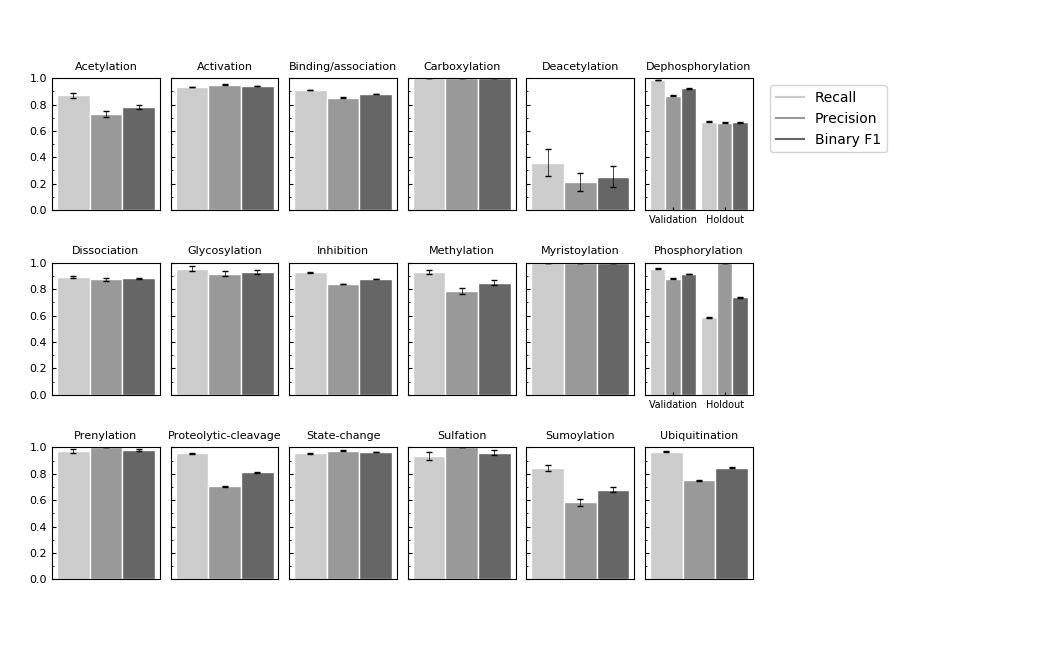

In [36]:
# Figure 2 from the paper
binary_df = pd.read_csv(
    "data/reference/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
dfs = {
    "Precision": binary_df,
    "Recall": binary_df,
    "Binary F1": binary_df
}
cmap = [0.8, 0.6, 0.4]
basic_bar_plot(dfs, cmap, labels, keys_are_metrics=True, plot_subsets=True);

# Appendix figure A.1 and A.2

This code constructs the visualisation for appendix figure A.1 and A.2. The two metrics are combined into a single plot. 

<IPython.core.display.Javascript object>


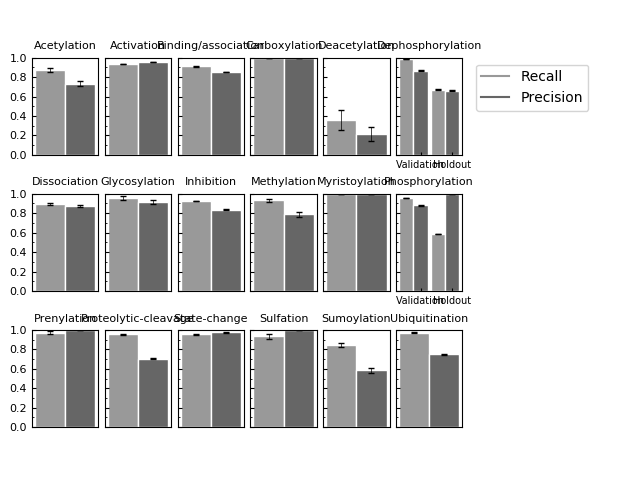

In [21]:
# Appendix figure A.1, A.2
binary_df = pd.read_csv(
    "data/reference/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
dfs = {
    "Precision": binary_df,
    "Recall": binary_df
}
cmap = [0.6, 0.4]
basic_bar_plot(dfs, cmap, labels, keys_are_metrics=True, plot_subsets=True);

# Appendix figure A.3

This code constructs the specificity plot. The validation and holdout results are both included since specificity can still be validly defined when no positive cases exist in the dataset (as in the case with our holdout set for many labels).

<IPython.core.display.Javascript object>


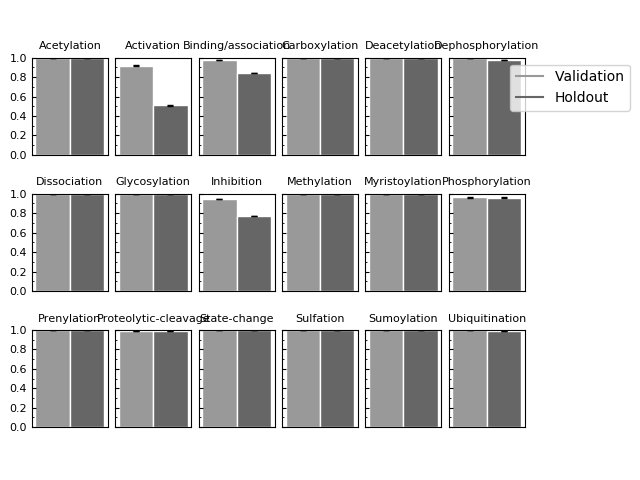

In [24]:
f = plt.figure()
binary_df = pd.read_csv(
    "data/reference/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
cmap = [0.6, 0.4]
ecolor='black'
edgecolor='white'

gs1 = GridSpec(3, 7)
gs1.update(left=0.05, right=0.95, wspace=0.1, hspace=0.4)
for i in range(0, 3):
    for j in range(0, 6):
        row_maj_idx = 6*i + j
        label = labels[row_maj_idx]
        
        ax = plt.subplot(gs1[i, j])
        ax.margins(0.05)
        
        # Limits config
        ax.set_ylim(bottom=0.0)
        ax.set_ylim(top=1.0)
               
        # Ticks config
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set(yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], yticklabels=[])
        minor_ticks = MultipleLocator(0.1)
        ax.yaxis.set_minor_locator(minor_ticks)
        ax.tick_params(axis='y', which='major', direction='in', length=3.0, labelsize=8)
        ax.tick_params(axis='y', which='minor', direction='in', length=1.5, labelsize=8)
        if row_maj_idx in [0, 6, 12]:
            ax.set(yticklabels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        
        # Title config
        ax.set_title(label.capitalize())
        ax.title.set_fontsize(8)
        
        # plot the data for each metric, using gray-scale colors               
        # Plot testing statistics for phosphorylation and dephosphorylation
        validation_x = [0.40]
        holdout_x = [0.60]
        subset_x = {"validation": validation_x, "holdout": holdout_x}
        bar_width = 0.20

        for idx, subset in enumerate(('validation', 'holdout')):
            spec = binary_df.loc[(label, subset, 'Specificity'), :].mean(axis=0, level=[0]).mean()
            stdev = binary_df.loc[(label, subset, 'Specificity'), :].std(axis=0, level=[0]).mean()
            stderr = stdev / np.sqrt(25) 
            ax.bar(
                left=subset_x[subset][0], height=spec, width=bar_width, yerr=stderr,
                color=str(cmap[idx]), ecolor=ecolor, edgecolor=edgecolor, linewidth=1.0,
                error_kw=dict(lw=0.5, capsize=2.5, label='Specificity')
            )

# Create the legend in a separate axis object at the right end.
ax = plt.subplot(gs1[:, -1])
line1 = mlines.Line2D([], [], color=str(cmap[0]), label='Validation')
line2 = mlines.Line2D([], [], color=str(cmap[1]), label='Holdout')
ax.legend(handles=[line1, line2], loc='upper center')
ax.set_axis_off()

plt.show()

# Appendix figure A.4

This code constructs the plot relating to the F1 score for alternate classifiers.

In [29]:
# TODO: GENERATE THESE DATASETS
logistic_df = binary_df = pd.read_csv(
    "data/reference/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
svm_df = binary_df = pd.read_csv(
    "data/reference/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
rf_df = binary_df = pd.read_csv(
    "data/reference/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)

dfs = {
    "Logistic Reg.": logistic_df,
    "Linear SVM": svm_df,
    "Random Forest": rf_df
}
cmap = [0.8, 0.6, 0.4]
basic_bar_plot(dfs, cmap, labels, plot_subsets=True);

<IPython.core.display.Javascript object>

# Appendix figure A.5

This code computes the figure that compares ULCA induction F1 score performance using logistic regression vs no feature induction.

<IPython.core.display.Javascript object>


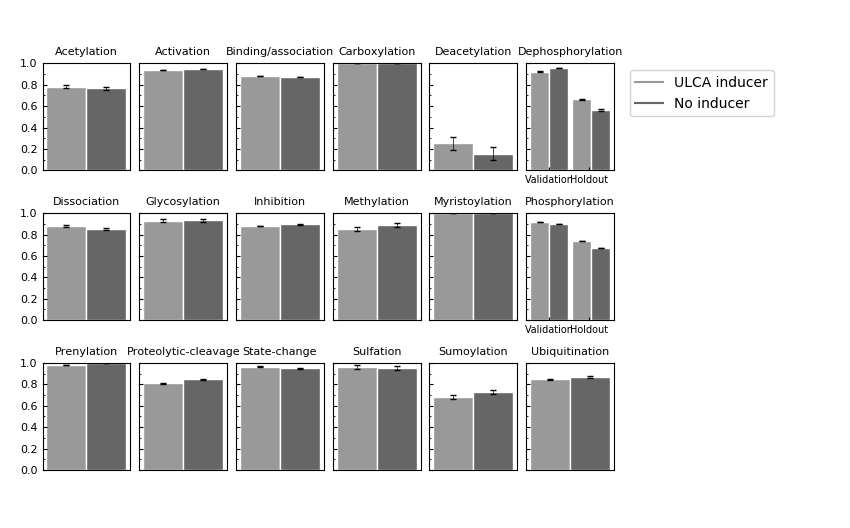

In [7]:
# TODO: GENERATE THESE DATASETS
ulca_df = binary_df = pd.read_csv(
    "data/reference/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
noulca_df = binary_df = pd.read_csv(
    "data/ten_iter/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)

dfs = {
    "ULCA inducer": ulca_df,
    "No inducer": noulca_df
}
cmap = [0.6, 0.4]
basic_bar_plot(dfs, cmap, labels, plot_subsets=True, center_left=0.12, center_right=0.62);

# Appendix figure A.6

This code computes the figure that compares binary feature encoding F1 score performance using logistic regression vs ternary feature encoding

In [31]:
# TODO: GENERATE THESE DATASETS
ternary_df = binary_df = pd.read_csv(
    "data/reference/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
binary_df = binary_df = pd.read_csv(
    "data/binary/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)

dfs = {
    "Binary encoding": binary_df,
    "Ternary encoding": ternary_df
}
cmap = [0.6, 0.4]
basic_bar_plot(dfs, cmap, labels, plot_subsets=True, center_left=0.12, center_right=0.62);

<IPython.core.display.Javascript object>

# Appendix figure A.7

This code computes the figure that compares the F1 performance of each feature subset.

In [32]:
# TODO: GENERATE THESE DATASETS
ipr_df = binary_df = pd.read_csv(
    "data/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
pf_df = binary_df = pd.read_csv(
    "data/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
cc_df = binary_df = pd.read_csv(
    "data/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
bp_df = binary_df = pd.read_csv(
    "data/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
mf_df = binary_df = pd.read_csv(
    "data/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)

dfs = {
    "InterPro": ipr_df,
    "Pfam": pf_df,
    "GO MF": mf_df,
    "GO BP": bp_df,
    "GO CC": cc_df
}
cmap = [0.6, 0.5, 0.4, 0.3, 0.2]
basic_bar_plot(dfs, cmap, labels, plot_subsets=True);

<IPython.core.display.Javascript object>

# Label Correlation Heatmap

This code produces the plot for the label correlation heatmap using the Spearman Correlation coefficient.

In [33]:
data = np.genfromtxt("data/reference/label_spearmanr.csv", skip_header=True, delimiter=',')
ticklabels = [l.capitalize() for l in labels]
fig, ax = plt.subplots(1, 1)

ax.set_xticks(range(0, 18))
ax.set_xticklabels(ticklabels, rotation=45, ha='right', fontdict={'size': 7})

ax.set_yticks(range(0, 18))
ax.set_yticklabels(ticklabels, fontdict={'size': 7})

im = ax.imshow(data, interpolation='none', cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(im)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

# Label Similarity Heatmaps

This code produces the plot for the label feature similarity heatmap using the Jaccard similarity measure.

The right subplot is the label feature similarity heatmap using the Jaccard similarity measure on the labels in the holdout set only.

<IPython.core.display.Javascript object>


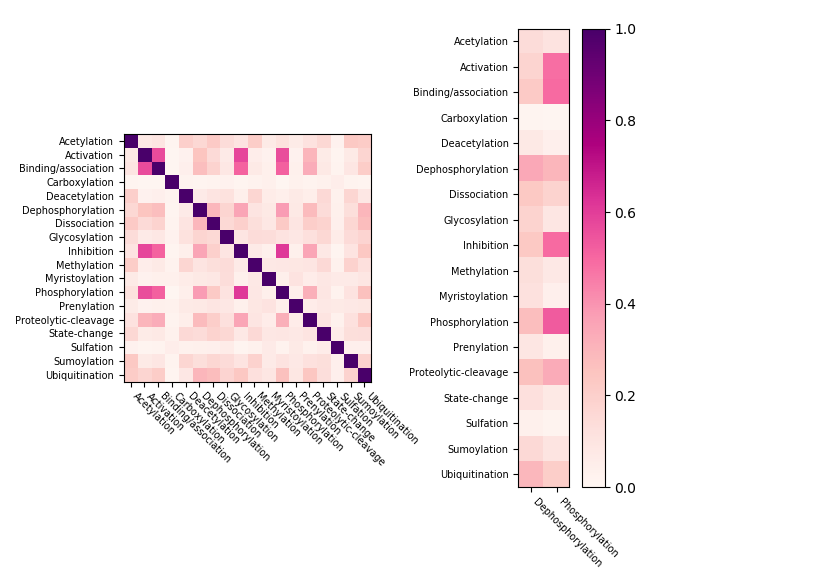

In [34]:
data1 = np.genfromtxt("data/reference/j_v_similarity_matrix.csv", skip_header=True, delimiter=',')
data2 = np.genfromtxt("data/reference/j_t_similarity_matrix.csv", skip_header=True, delimiter=',')

v_ticklabels = [l.capitalize() for l in labels]
t_ticklabels = [l.capitalize() for l in sorted(('phosphorylation', 'dephosphorylation'))]

fig = plt.figure()
gs = GridSpec(
    1, 2, width_ratios=[1, 1], 
    wspace=0.0, hspace=0.0, 
    top=0.95, bottom=0.15, left=0.15, right=0.75
)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

ax1.set_xticks(range(0, 18))
ax1.set_xticklabels(v_ticklabels, rotation=315, ha='left', fontdict={'size': 7})
ax1.set_yticks(range(0, 18))
ax1.set_yticklabels(v_ticklabels, fontdict={'size': 7})

ax2.set_xticks(range(0, 18))
ax2.set_xticklabels(t_ticklabels, rotation=315, ha='left', fontdict={'size': 7})
ax2.set_yticks(range(0, 18))
ax2.set_yticklabels(v_ticklabels, fontdict={'size': 7})
    
im1 = ax1.imshow(data1, interpolation='none', cmap='RdPu', vmin=0, vmax=1)
im2 = ax2.imshow(data2.T, interpolation='none', cmap='RdPu', vmin=0, vmax=1)
fig.colorbar(im1)

# plt.tight_layout()
plt.show()

# Paper Figure 3

This code computes the threshold curve giving the proportion of the interactome classified at a probability threshold t or greater.

In [35]:
thresholds = []
proportions = []
with open('data/reference/thresholds.csv', 'rt') as fp:
    reader = csv.reader(fp)
    for row in reader:
        thresholds.append(float(row[0]))
        proportions.append(float(row[1]))

plt.style.use('default')
fig, ax = plt.subplots(1, 1)
ax.plot(thresholds, proportions, color='black', linewidth='1')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xticklabels(np.arange(0, 1.1, 0.1), fontdict={'size': 7})
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels(np.arange(0, 1.1, 0.1), fontdict={'size': 7})
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/thresholds.csv'